In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "New simulation implementation and attempt to find sparsity in histogram reproduction"
nb_name = "nb_seqsim_find_sparsity"

# Core

In [2]:
core = SDSS(comment, N_SH = 30, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = 30, r_at = core.r_cmb)

grid_in = np.array([core.grid_glq_phi, 90-core.grid_glq_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)


In [3]:
core.generate_map()

<IPython.core.display.Javascript object>


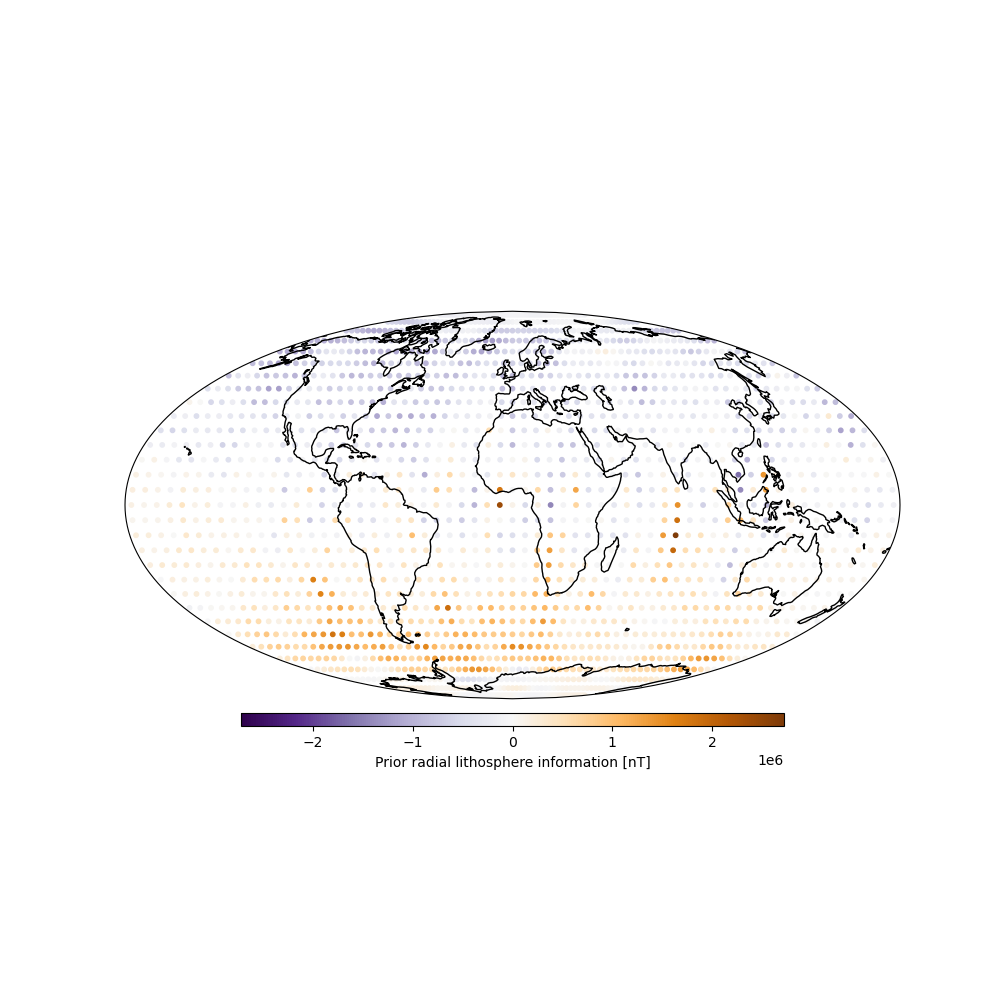

In [4]:
mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
                            data=core.data, point_size=10, shift_grid = True, 
                            transpose_grid = True, shape = (121,61), cmap = 'PuOr_r', 
                            title="Prior radial lithosphere information")

In [7]:
core.condtab(normsize=10001, quantiles = 1000)

In [8]:
core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


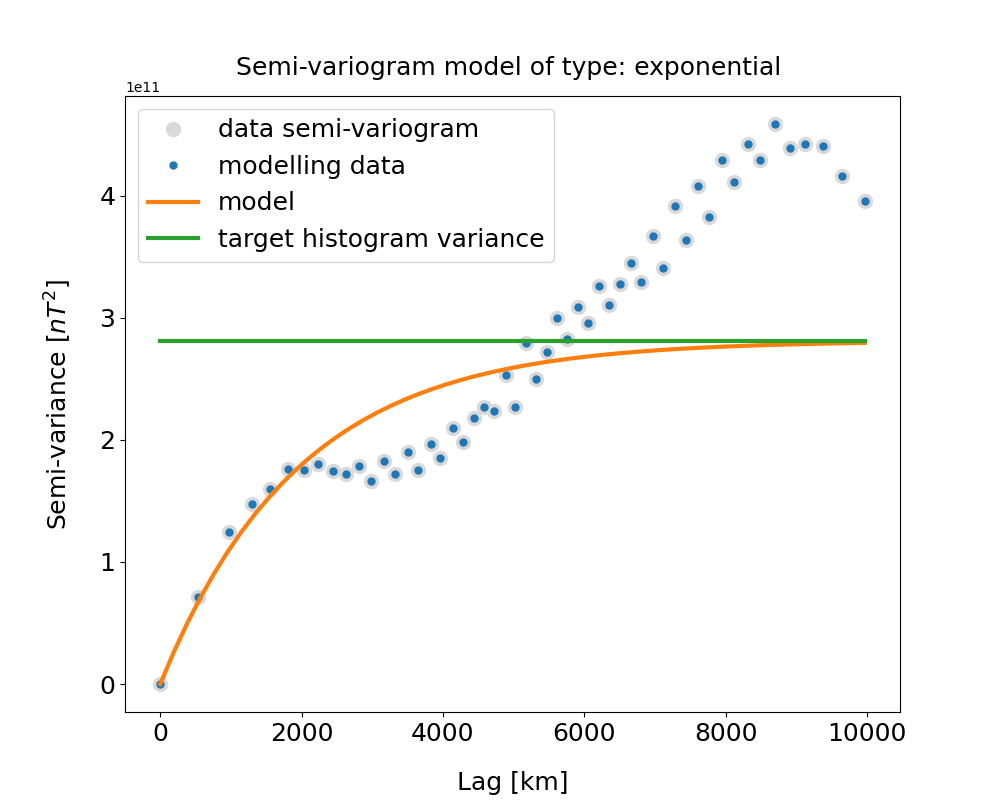

In [9]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',linewidth = 3,label='model')
plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3, color="C2", label="target histogram variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [10]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               New simulation implementation and attempt to find sparsity in histogram reproduction
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core
grid_glq_zero:         (31,), Max/Min: 1.00 / -1.00
grid_glq_w_shtools:    (31,), Max/Min: 0.10 / 0.01
grid_glq_shape:        (2,), Max/Min: 61.00 / 31.00
grid_glq_w:            (1891,), Max/Min: 0.10 / 0.01
grid_glq_radial:       (1891,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (1891,), Max/Min: 175.63 / 4.37
grid_glq_phi:          (1891,), Max/Min: 354.10 / 0.00
grid_glq_N:            1891
grid_glq_nmax:         30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891

# Synthetic sat

In [11]:
s_sat = SDSS(comment, N_SH = 30, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.swarm_phi, 90-s_sat.swarm_theta]).T
s_sat.make_grid(s_sat.swarm_radius, grid_in, calc_sph_d = False)

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_eqa_phi, 90-s_sat.grid_eqa_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)

In [12]:
s_sat.generate_map(grid_type = "swarm")

<IPython.core.display.Javascript object>


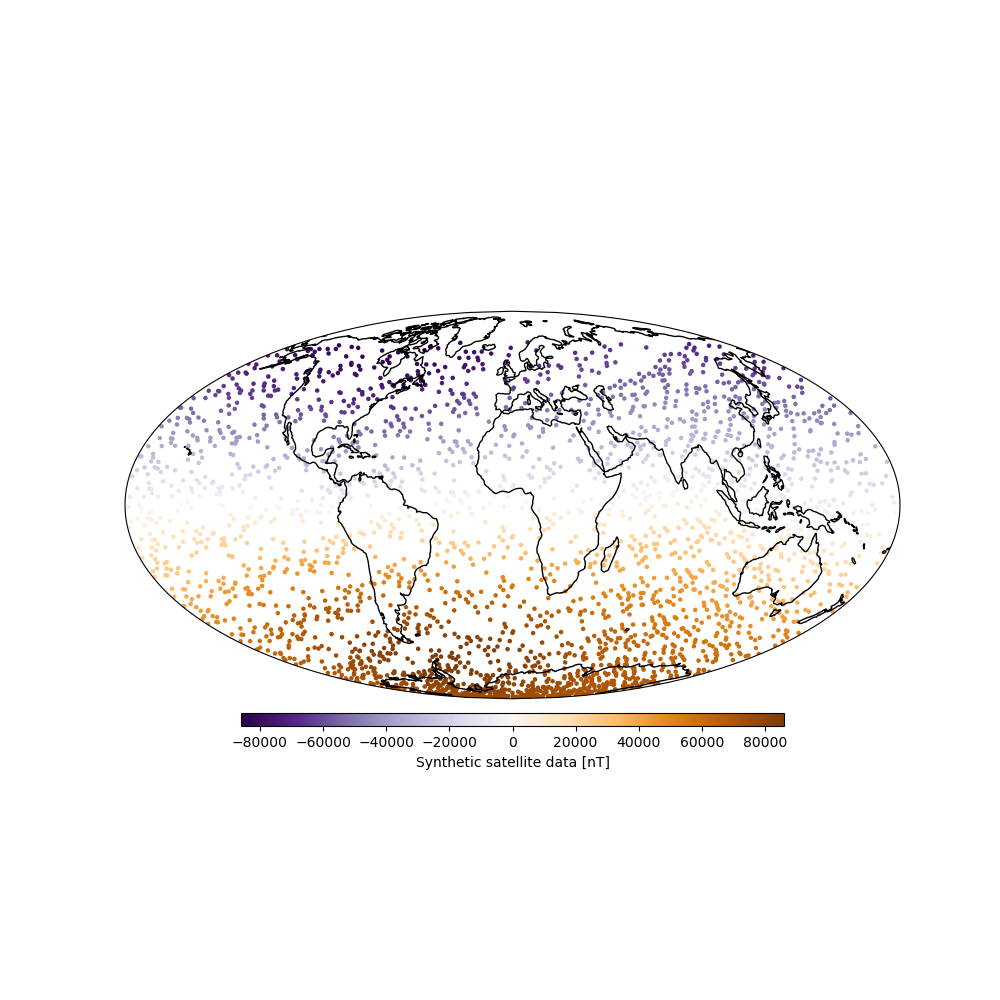

In [13]:
mt_util.plot_cartopy_global(lat = s_sat.lat, lon = s_sat.lon, plot_quality = "high", point_size=5, 
                            data=s_sat.data, cmap = 'PuOr_r', title="Synthetic satellite data")

In [14]:
print(s_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          New simulation implementation and attempt to find sparsity in histogram reproduction
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core
swarm_theta:      (2773,), Max/Min: 177.35 / 22.39
swarm_phi:        (2773,), Max/Min: 179.68 / -179.59
swarm_radius:     (2773,), Max/Min: 6825.19 / 6806.85
swarm_obs:        (2773,), Max/Min: 53117.43 / -48881.72
swarm_N:          2773
r_grid:           (2773,), Max/Min: 6825.19 / 6806.85
grid:             (2773, 2)
sph_d:            None
lon:              (2773,), Max/Min: 179.68 / -179.59
lat:              (2773,), Max/Min: 67.61 / -87.35
N_grid:           2773
B_ensemble_swarm: (2773, 3)
data:             (2773,), Max/Min: 85907.58 / -84355.41
target_var:      


Gauss-Legendre RMSE:	 0.000006338655


<IPython.core.display.Javascript object>


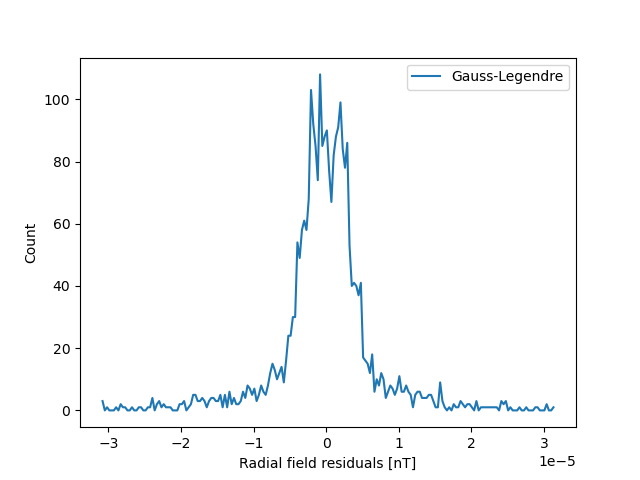

In [17]:
core.integrating_kernel(s_sat, C_e_const = 3)

In [18]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               New simulation implementation and attempt to find sparsity in histogram reproduction
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core
grid_glq_zero:         (31,), Max/Min: 1.00 / -1.00
grid_glq_w_shtools:    (31,), Max/Min: 0.10 / 0.01
grid_glq_shape:        (2,), Max/Min: 61.00 / 31.00
grid_glq_w:            (1891,), Max/Min: 0.10 / 0.01
grid_glq_radial:       (1891,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (1891,), Max/Min: 175.63 / 4.37
grid_glq_phi:          (1891,), Max/Min: 354.10 / 0.00
grid_glq_N:            1891
grid_glq_nmax:         30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891

In [ ]:
N_sim = 6

core.run_sim(N_sim, core.grid_glq_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, sense_running_error = True, save_string = nb_name)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.1
Run time: 8.270 minutes 
Total elapsed time: 8.270 minutes 
Variance: 253763243890.245
Mean: -10768.097
Max: 1805778.035
Min: -1256398.469
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.1
Run time: 8.243 minutes 
Total elapsed time: 16.512 minutes 
Variance: 254566423979.774
Mean: -10866.474
Max: 1735746.747
Min: -1325850.571
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.2
Run time: 8.157 minutes 
Total elapsed time: 24.670 minutes 
Variance: 255697159365.808
Mean: -9161.970
Max: 1615852.471
Min: -1421044.639
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.1
Run time: 8.199 minutes 
Total elapsed time: 32.868 minutes 
Variance: 248945491667.573
Mean: -12156.187
Max: 1802773.878
Min: -1365106.771
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realiza

In [16]:
core.realization_to_sh_coeff(core.r_cmb)

In [17]:
core.covmod_lsq_equiv(s_sat.data, core.C_mm_all, core.G, core.r_cmb)

In [18]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

<module 'mikkel_tools.utility' from '/home/mikotz/spherical_direct_sequential_simulation/mikkel_tools/utility.py'>

In [19]:
core.grid_glq(nmax = 30, r_at = core.a)

<IPython.core.display.Javascript object>


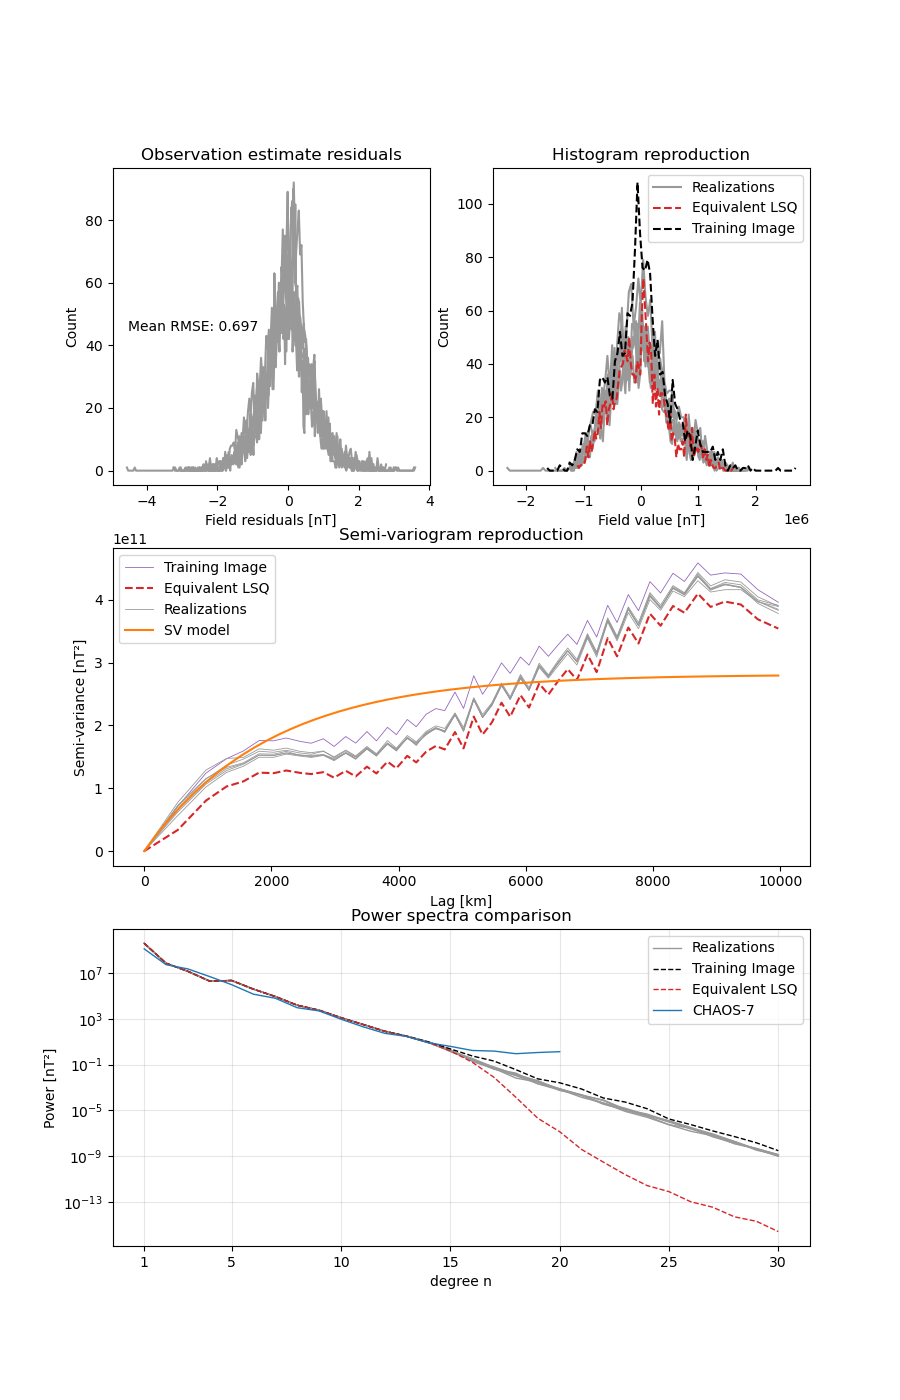

In [20]:

mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq,
                              lags_use = 1000, spec_r_at = core.r_sat,
                              model_dict = {"CHAOS-7"}, figsize=(9,14),
                              savefig = False, save_string = "core_A_sh30")

In [21]:
#core.grid_glq(nmax = 256, r_at = core.a)
core.grid_glq(nmax = 120, r_at = core.a)

core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble_glq[:,0,:].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(30)], nmax = 30, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble_glq[:,0].copy()

<IPython.core.display.Javascript object>


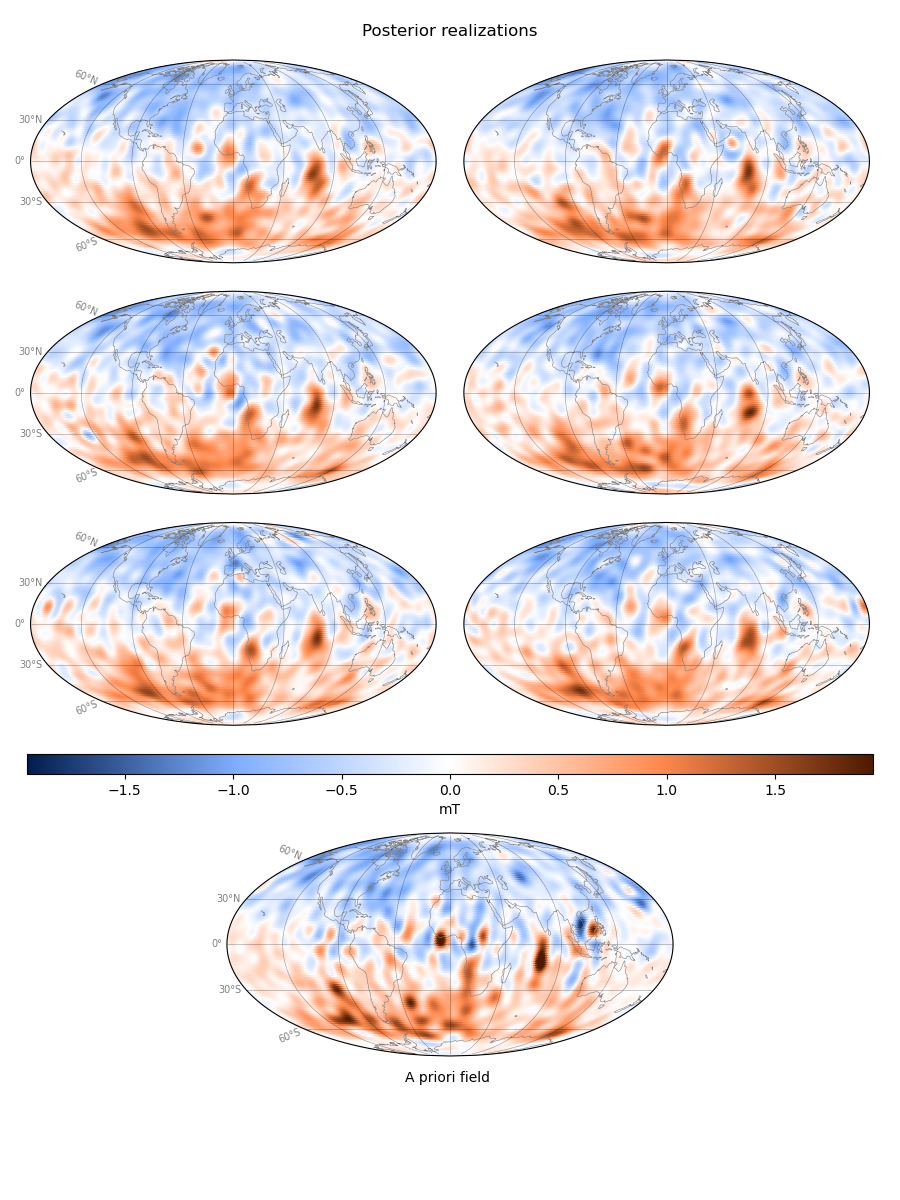

In [24]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_glq_phi, 90-core.grid_glq_theta, zs_eqa, 
                        field_compare = prior_eqa, tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "core_A_sh30", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


In [23]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")